In [21]:
import pandas as pd
import numpy as np
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_predict
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor
from scipy.optimize import minimize
from tqdm import tqdm
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge

In [ ]:
#data
train=pd.read_csv("../dataset/train_features.csv")
y=pd.read_csv("../dataset/train_labels.csv")
test=pd.read_csv("../dataset/test_features.csv")
ss=pd.read_csv("../dataset/submission_format.csv")

In [3]:
train.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [4]:
test.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,abxu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
1,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 4.6+ MB


In [6]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='left')

In [7]:
merged_df["year"]

0       2021
1       2021
2       2016
3       2021
4       2021
        ... 
4338    2021
4339    2016
4340    2021
4341    2021
4342    2021
Name: year, Length: 4343, dtype: int64

In [8]:
#so many missing values
merged_df.isnull().sum()

uid                   0
age_03             1456
urban_03           1454
married_03         1454
n_mar_03           1482
                   ... 
a33b_12            4288
a34_12             1601
j11_12               89
year                  0
composite_score       0
Length: 186, dtype: int64

In [9]:
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

In [10]:
merged_test["year"]

0       2016
1       2016
2       2021
3       2016
4       2021
        ... 
1100    2016
1101    2021
1102    2016
1103    2021
1104    2021
Name: year, Length: 1105, dtype: int64

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

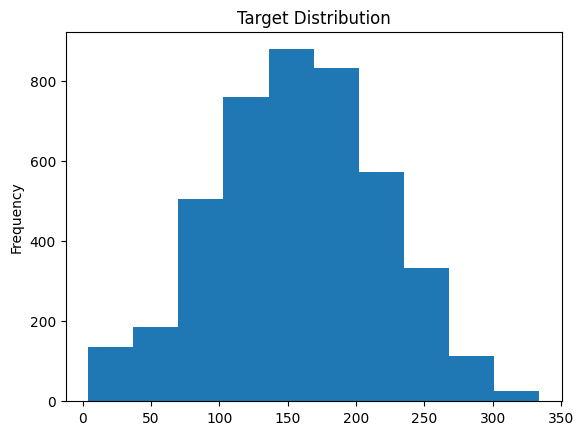

In [11]:
merged_df['composite_score'].plot(kind='hist',title='Target Distribution')

In [12]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data=data.drop(columns=['uid','composite_score'],axis=1)

# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

In [13]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [15]:
merged_df.shape

(4343, 184)

In [22]:
fold_results = []
oof_predictions = np.zeros_like(y, dtype=float)
oof_pred1 = np.zeros_like(y, dtype=float)
oof_pred2 = np.zeros_like(y, dtype=float)
oof_pred3 = np.zeros_like(y, dtype=float)
model1s = []
model2s = []
model3s = []    

# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate through folds
for fold, (train_index, val_index) in enumerate(tqdm(kf.split(merged_df))):
    # Split the data
    train_X, val_X = merged_df.iloc[train_index], merged_df.iloc[val_index]
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]

    # Train LightGBM
    model1 = lgb.LGBMRegressor(
        learning_rate=0.01, 
        n_estimators=1000, 
        random_state=42,
        metric='RMSE'
    )
    model1.fit(train_X, train_y, eval_set=[(val_X, val_y)])
    model1s.append(model1)
    pred1 = model1.predict(val_X, num_iteration=model1.best_iteration_)
    
    # Store out-of-fold predictions for LightGBM
    oof_pred1[val_index] = pred1

    # Train CatBoost
    model2 = CatBoostRegressor(
        iterations=10000, 
        learning_rate=0.01, 
        depth=10, 
        loss_function='RMSE',
        cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
        verbose=100, 
        early_stopping_rounds=500
    )
    model2.fit(train_X, train_y, eval_set=(val_X, val_y))
    model2s.append(model2)
    pred2 = model2.predict(val_X)
    
    # Store out-of-fold predictions for CatBoost
    oof_pred2[val_index] = pred2
    
    # Train XGBoost
    model3 = XGBRegressor(
        n_estimators=10000, 
        learning_rate=0.01,
        max_depth=3, 
        random_state=42, 
        enable_categorical=True,
        eval_metric=root_mean_squared_error,
        early_stopping_rounds=500
    )
    model3.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=100)
    model3s.append(model3)
    pred3 = model3.predict(val_X)
    
    # Store out-of-fold predictions for XGBoost
    oof_pred3[val_index] = pred3

# Prepare meta-features for final stacking
meta_features = np.column_stack([oof_pred1, oof_pred2, oof_pred3])

# Train meta-model (Ridge regression)
meta_model = Ridge(alpha=1.0)
meta_model.fit(meta_features, y)

0it [00:00, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 184
[LightGBM] [Info] Start training from score 157.136730
0:	learn: 61.0968399	test: 58.8058395	best: 58.8058395 (0)	total: 77.2ms	remaining: 12m 51s
100:	learn: 45.4410279	test: 45.6028066	best: 45.6028066 (100)	total: 2.43s	remaining: 3m 58s
200:	learn: 39.0878675	test: 41.5456612	best: 41.5456612 (200)	total: 5.23s	remaining: 4m 15s
300:	learn: 35.5986901	test: 39.9273411	best: 39.9273411 (300)	total: 8.11s	remaining: 4m 21s
400:	learn: 33.2094891	test: 39.1314163	best: 39.1314163 (400)	total: 10.8s	remaining: 4m 18s
500:	learn: 31.4176779	test: 38.6480547	best: 38.6480547 (500)	total: 13.4s	remaining: 4m 14s
600:	learn: 30.1218652	test: 3

1it [05:19, 319.80s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1558
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 184
[LightGBM] [Info] Start training from score 157.271445
0:	learn: 59.9979103	test: 63.2095608	best: 63.2095608 (0)	total: 22.5ms	remaining: 3m 45s
100:	learn: 45.1486532	test: 47.5175717	best: 47.5175717 (100)	total: 2.37s	remaining: 3m 52s
200:	learn: 39.0906320	test: 42.2019668	best: 42.2019668 (200)	total: 5.07s	remaining: 4m 7s
300:	learn: 35.7810579	test: 40.0875359	best: 40.0875359 (300)	total: 7.98s	remaining: 4m 17s
400:	learn: 33.4582687	test: 39.0410680	best: 39.0410680 (400)	total: 10.9s	remaining: 4m 20s
500:	learn: 31.8339698	test: 38.4222289	best: 38.4222289 (500)	total: 14.1s	remaining: 4m 28s
600:	learn: 30.4534694	test: 38.

2it [10:30, 314.30s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 184
[LightGBM] [Info] Start training from score 156.375360
0:	learn: 60.9011270	test: 59.6063548	best: 59.6063548 (0)	total: 35.4ms	remaining: 5m 53s
100:	learn: 45.0866310	test: 46.6020960	best: 46.6020960 (100)	total: 2.28s	remaining: 3m 43s
200:	learn: 38.8123756	test: 42.7566805	best: 42.7566805 (200)	total: 4.92s	remaining: 4m
300:	learn: 35.1670499	test: 41.0863368	best: 41.0863368 (300)	total: 7.81s	remaining: 4m 11s
400:	learn: 32.7953003	test: 40.3183533	best: 40.3183533 (400)	total: 10.6s	remaining: 4m 14s
500:	learn: 31.0434299	test: 39.8397078	best: 39.8397078 (500)	total: 13.6s	remaining: 4m 17s
600:	learn: 29.7852070	test: 39.556

3it [15:22, 304.29s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 3475, number of used features: 184
[LightGBM] [Info] Start training from score 157.237122
0:	learn: 60.6014303	test: 60.7946485	best: 60.7946485 (0)	total: 18.7ms	remaining: 3m 6s
100:	learn: 45.1270455	test: 46.8539846	best: 46.8539846 (100)	total: 2.18s	remaining: 3m 34s
200:	learn: 38.8983723	test: 42.3812053	best: 42.3812053 (200)	total: 4.77s	remaining: 3m 52s
300:	learn: 35.4510649	test: 40.6666022	best: 40.6666022 (300)	total: 7.57s	remaining: 4m 3s
400:	learn: 33.2082143	test: 39.8262530	best: 39.8262530 (400)	total: 10.4s	remaining: 4m 9s
500:	learn: 31.5916940	test: 39.3422105	best: 39.3422105 (500)	total: 13.1s	remaining: 4m 8s
600:	learn: 30.3353372	test: 39.0297971	best: 39.0297971 (600)	total: 16s	remaining: 4m 9s
700:	lea

4it [22:04, 342.91s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 3475, number of used features: 184
[LightGBM] [Info] Start training from score 157.063309
0:	learn: 60.6063864	test: 60.8112299	best: 60.8112299 (0)	total: 28.9ms	remaining: 4m 48s
100:	learn: 44.6720446	test: 47.5307961	best: 47.5307961 (100)	total: 2.31s	remaining: 3m 46s
200:	learn: 38.3069288	test: 43.9226278	best: 43.9226278 (200)	total: 4.99s	remaining: 4m 3s
300:	learn: 34.8000820	test: 42.5284960	best: 42.5284960 (300)	total: 7.88s	remaining: 4m 14s
400:	learn: 32.6221258	test: 41.9003158	best: 41.9003158 (400)	total: 10.7s	remaining: 4m 15s
500:	learn: 31.0140313	test: 41.4877224	best: 41.4877224 (500)	total: 13.5s	remaining: 4m 15s
600:	learn: 29.6661111	test: 41.

5it [27:45, 333.11s/it]


Ridge()

In [23]:
meta_features

array([[124.50211424, 120.93168394, 132.62762451],
       [205.26555001, 203.945724  , 180.48942566],
       [180.10239722, 171.09661909, 171.8901825 ],
       ...,
       [118.51614664, 130.21309122, 112.2967453 ],
       [ 90.67817364,  90.58188999, 101.14942932],
       [119.64547839, 114.9325633 , 111.39398193]])

In [24]:
y

0       175
1       206
2       161
3       144
4       104
       ... 
4338    152
4339    140
4340    121
4341     32
4342    147
Name: composite_score, Length: 4343, dtype: int64

In [25]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for storing results
fold_results = []
optimized_weights_list = []
index = 0

for _, val_index in tqdm(kf.split(merged_df)):
    # Split the data
    val_X = merged_df.iloc[val_index]
    val_y = y.iloc[val_index]
    
    model1 = model1s[index]
    pred1 = model1.predict(val_X, num_iteration=model1.best_iteration_)
    
    model2 = model2s[index]
    pred2 = model2.predict(val_X)
    
    model3 = model3s[index]
    pred3 = model3.predict(val_X)
    
    base_preds = np.column_stack([
        pred1, pred2, pred3
    ])

    final_predictions = meta_model.predict(base_preds)

    # Store results
    fold_mse = root_mean_squared_error(val_y, final_predictions)  # RMSE
    fold_results.append(fold_mse)

# Display results
print(f"Average MSE across folds: {np.mean(fold_results)}")


5it [00:00,  7.44it/s]

Average MSE across folds: 21.563116107059024


In [34]:
val_y

4       104
9       144
11      193
16       92
19       84
       ... 
4319    149
4330    128
4336    241
4337    155
4338    152
Name: composite_score, Length: 868, dtype: int64

In [ ]:
# Train models on the entire training dataset
final_model1 = lgb.LGBMRegressor(
    learning_rate=0.01, n_estimators=1000, random_state=42,
     metric='RMSE' # feature_fraction=0.8, bagging_fraction=0.8,
)
final_model1.fit(merged_df, y)

final_model2 = CatBoostRegressor(
    iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE',
    cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    verbose=100
)
final_model2.fit(merged_df, y)

final_model3 = XGBRegressor(n_estimators=10000, learning_rate=0.01,
        max_depth=3, random_state=42, 
        enable_categorical=True,
        eval_metric=root_mean_squared_error)
final_model3.fit(merged_df, y)

# Final prediction process for test set
def stacked_predict(X):
    base_preds = np.column_stack([
        final_model1.predict(X),
        final_model2.predict(X),
        final_model3.predict(X)
    ])
    return meta_model.predict(base_preds)

# Generate final predictions
final_test_predictions = stacked_predict(merged_test)

# Optionally round predictions if required (e.g., for classification tasks)
final_test_predictions = np.round(final_test_predictions).astype(int)

# Display final predictions
print("Final blended predictions for the test dataset:")
print(final_test_predictions)

ss['composite_score']=final_test_predictions
#generate submission
ss.to_csv('../dataset/LGBM_and_CatBoost_and_XGBoost_stacking_2.csv', index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1653
[LightGBM] [Info] Number of data points in the train set: 4343, number of used features: 184
[LightGBM] [Info] Start training from score 157.016809
0:	learn: 60.6445520	total: 43.3ms	remaining: 7m 12s
100:	learn: 45.0332493	total: 2.56s	remaining: 4m 10s
200:	learn: 38.9044928	total: 5.61s	remaining: 4m 33s
300:	learn: 35.5399273	total: 8.49s	remaining: 4m 33s
400:	learn: 33.3917089	total: 11.2s	remaining: 4m 29s
500:	learn: 31.8994396	total: 14.1s	remaining: 4m 26s
600:	learn: 30.7114954	total: 16.8s	remaining: 4m 22s
700:	learn: 29.6846195	total: 19.6s	remaining: 4m 19s
800:	learn: 28.8254993	total: 22.2s	remaining: 4m 15s
900:	learn: 27.9642830	total: 25.1s	remaining: 4m 13s
1000:	learn: 27.1063650	total: 28.2s	remaining: 4m 13

: 